# 6-2. CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기



In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- 데이터 다운로드

stanford_dogs 데이터셋은 12,000장의 학습용 데이터셋과 8,580장의 평가용 데이터셋으로 구성되어있습니다. tfds.load()를 활용해서 데이터셋을 다운로드 해주세요.

In [ ]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


tfds.show_examples() 를 통해서 각 이미지의 클래스와 그 인덱스(index)를 확인할 수 있다.

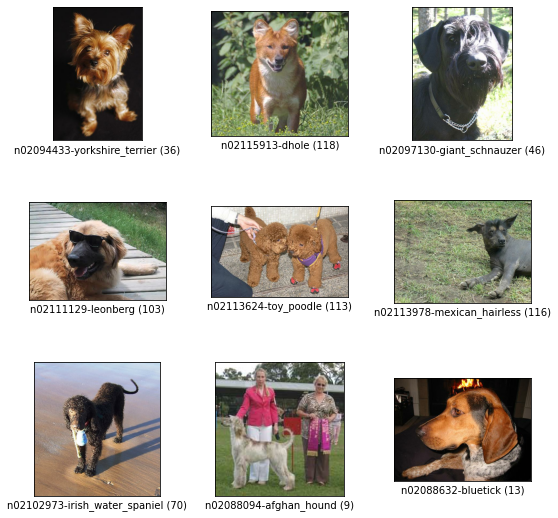

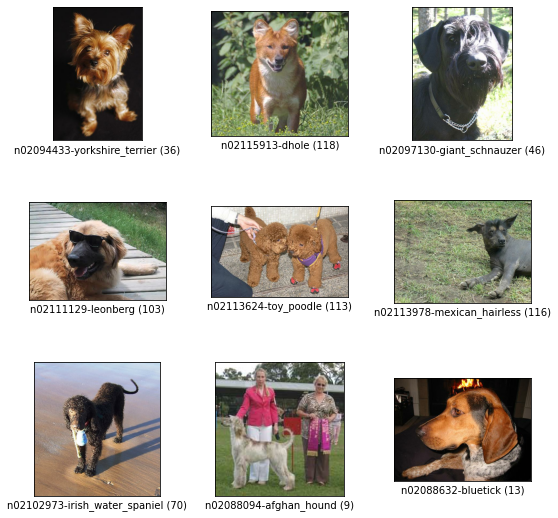

In [ ]:
tfds.show_examples(ds_train, ds_info)

테스트 셋도 확인

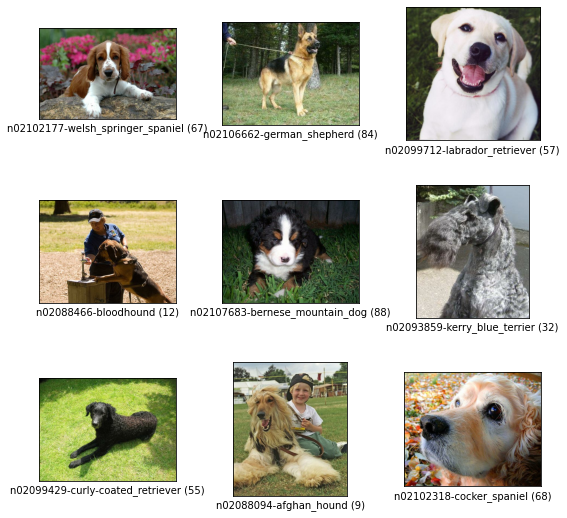

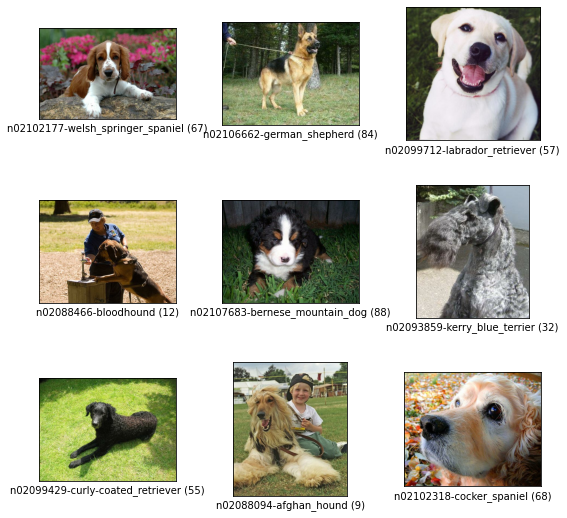

In [ ]:
tfds.show_examples(ds_test, ds_info)

# 6-3. CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보

ds_info.features를 조회해본다.

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

BBoxFeature는 바운딩 박스의 좌표값을 [ymin, xmin, ymax, xmax] 이런 식으로 표기한다. 좌상단과 우하단의 위치다.

# 6-4. CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기

모델은 이미지넷 데이터로 훈련된 ResNet50을 기반으로 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만든다.

CAM 모델은 classification모델들과 크게 다른 점은 없다. 다만 마지막 fc layer대신 GAP을 사용해야 한다. 
ResNet의 매개변수 pooling에 avg를 매개변수로 전달하면 GAP 연산을 붙일 수 있다.

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [ ]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

conv5_block3_out (Activation)  (None, 7, 7, 2048) 의 output이 feature map이 된다. 이 feature map에 Global average pooling (GAP)을 해서 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 한다. 

# 6-5. CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기

훈련, 테스트 셋에 normalizing과 resizing을 포함한 간단한 전처리를 normalize_and_resize_img() 에서 수행.

이를 포함하여 apply_normalize_on_dataset()에서 배치를 구성.


input에 bbox 정보가 포함되어 있지만 지금 수행하는 CAM모델의 학습에는 필요가 없기 때문에  normalize_and_resize_img과정에서 제외했다. CAM모델은  object detection이나 segmentation에도 활용될 수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이다. 

In [ ]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


In [ ]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


모델을 컴파일하고 학습한다. 2 epochs만 해본다. 뒤에서 미리 학습된 가중치를 불러온다. 

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

print('슝=3')

슝=3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# history_cam_model = cam_model.fit(
#     ds_train_norm,
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=2,
#     validation_data=ds_test_norm,
#     verbose=1,
#     use_multiprocessing=True,
# )

Epoch 1/2
750/750 [==============================] - 115s 128ms/step - loss: 2.2081 - accuracy: 0.4443 - val_loss: 3.6451 - val_accuracy: 0.1786
Epoch 2/2
750/750 [==============================] - 94s 125ms/step - loss: 0.6906 - accuracy: 0.8127 - val_loss: 1.0596 - val_accuracy: 0.6924


학습시킨 가중치를 저장한다.



In [ ]:
# 학습시킨 가중치를 저장하는 코드

# cam_model_path = '/content/drive/MyDrive/Aiffel/LMS/6'
# cam_model.save(cam_model_path)
# print("저장 완료!")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Aiffel/LMS/6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Aiffel/LMS/6/assets


저장 완료!


# 6-6. CAM

학습된 모델을 활용해서 CAM을 생성해본다. 

In [ ]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


학습된 모델에서 CAM을 생성해 본다. CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에 get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했다.

In [99]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


80


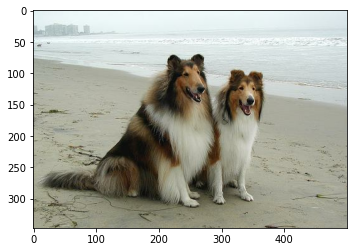

In [100]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [ ]:
import os
cam_model_path = '/content/drive/MyDrive/Aiffel/6/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


CAM을 생성하려면 1. 특성 맵, 2. 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 3. 원하는 클래스의 출력값이 필요하다. 

이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 한다. 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 한다. 

generate_cam()을 구현하기 위해 conv_outputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현했다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize했다. 

In [ ]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('슝=3')

슝=3


위에서 작성한 함수를 실행하면 아래와 같은 CAM을 얻을 수 있다.

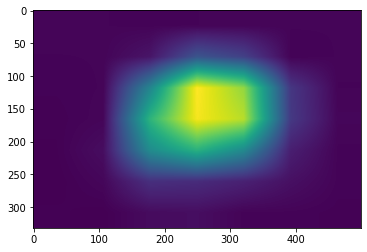

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

그려진 CAM 이미지를 원본 이미지와 합쳐본다.

In [ ]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝=3')

슝=3


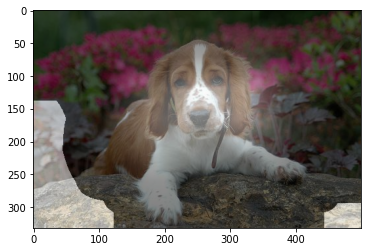

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

잘 그려지는 것을 확인할 수 있다. 

# 6-7. Grad-CAM

Grad-CAM을 이용해서 CAM을 얻어본다. 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 cam_model을 그대로 활용한다. 

우선 새로운 이미지를 뽑아본다.

108


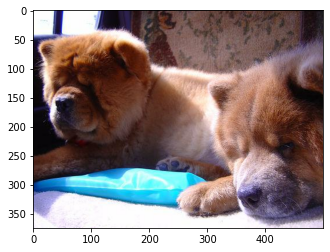

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

grad_cam은 관찰을 원하는 레이어의 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP연산을 적용함으로 관찰 대상이 되는 레이어의 채널별 가중치를 구한다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 된다. 

CAM 함수와 달리 Grad_CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 합니다. 

아래 generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용한다. 

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 본다. 레이어의 이름은 이전 스탭의 cam_model.summary() 결과에서 찾을 수 있다.

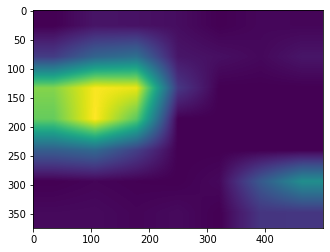

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

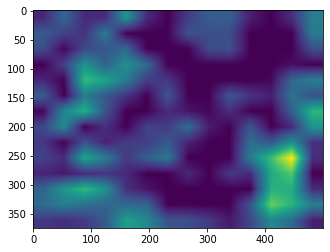

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

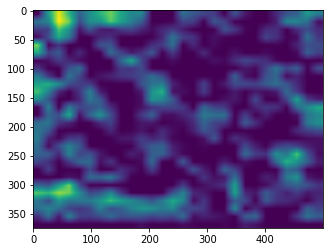

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

# 6-8. Detection with CAM

- 바운딩 박스

마지막으로 이번에는 CAM에서 물체의 위치를 찾는 detection을 해본다. 

우선 새로운 이미지를 다시 뽑아 CAM 이미지를 뽑아본다.


67


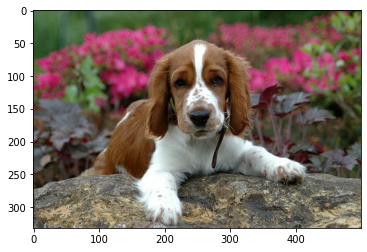

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

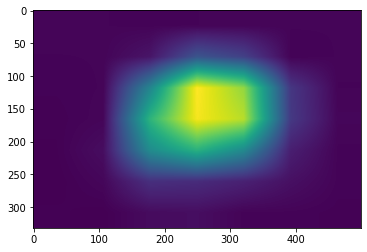

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

이전 스탭에서 만들었던 generate_cam()을 활용해서 CAM 이미지를 뽑았다. 

아래 get_bbox() 함수는 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스를 없앤다. 그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾는다. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있다. boxPoints()로 이를 꼭지점으로 바꿔준다. 마지막에는 int로 변환한다.

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


아래에서 cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화한 모습을 볼 수 있다. 

In [ ]:
rect = get_bbox(cam_image)
rect

array([[111, 294],
       [111,  33],
       [443,  33],
       [443, 294]])

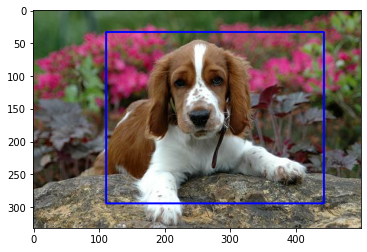

In [ ]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Intersection Over Union

위에서 CAM과 Grad-CAM 두 가지 방법을 통해서 바운딩 박스를 얻을 수 있었다. 그럼 정답 데이터인 바운딩 박스와 이를 어떻게 비교, 평가 할 수 있을까?

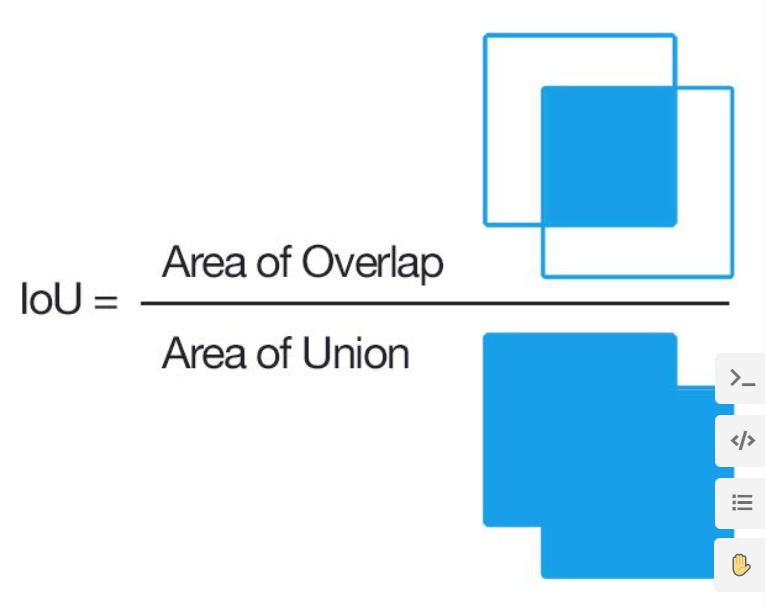

IoU(Intersection over Union)는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값이다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다. 

In [ ]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


위에서 구했던 rect를 minmax bbox 형태로 치환한다. 

In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09939759036144578, 0.222, 0.8855421686746988, 0.886]

이 데이터의 ground truth bbox를 확인해 본다.

In [ ]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 비슷하게 얻어졌는지 IoU를 계산해서 확인해 본다.

In [ ]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6983858334151163

# 6-9. 프로젝트: CAM을 만들고 평가해 보자

라이브러리 버전 확인

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.8.0
1.21.5
4.1.2
7.1.2


## CAM 구현하기

1. CAM을 직접 구현하기

In [153]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, class_idx = normalize_and_resize_img(item)

    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) 
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

2. 만든 함수로 CAM 이미지를 생성

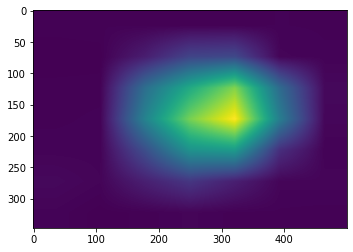

In [171]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어본다.

In [155]:
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

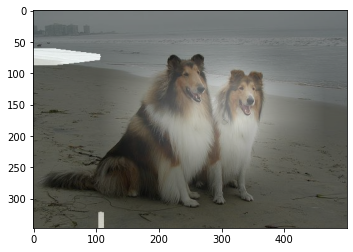

In [172]:
# visualize_cam_on_image() 함수 사용

type(item['image'])

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## Grad-CAM 구현

1. Grad-CAM을 직접 구현한다. 

In [157]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] 
        output = conv_output[0] 
        grad_val = tape.gradient(loss, conv_output)[0] 

    weights = np.mean(grad_val, axis=(0, 1)) 
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 본다.

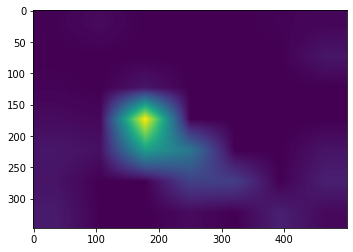

In [176]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

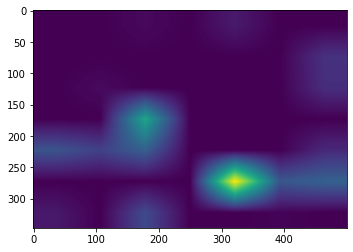

In [181]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block2_out', item)
plt.imshow(grad_cam_image)
plt.show()

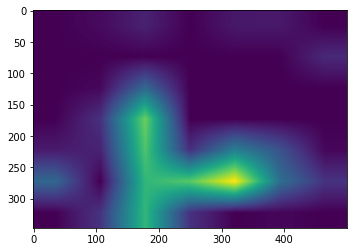

In [182]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block1_out', item)
plt.imshow(grad_cam_image)
plt.show()

3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화한다.

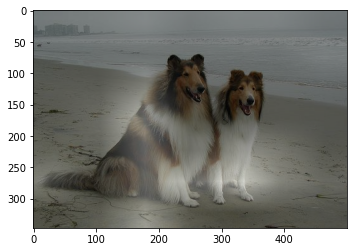

In [183]:
type(item['image'])

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 바운딩 박스 구하기

1. 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어본다.

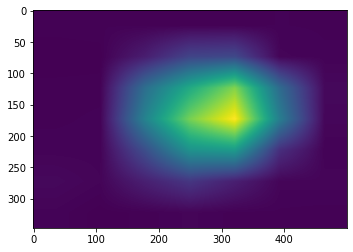

In [162]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

2. 바운딩 박스를 시각화한다. 

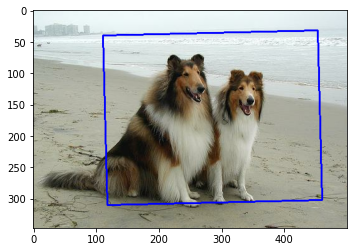

In [163]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

rect = get_bbox(cam_image)

image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

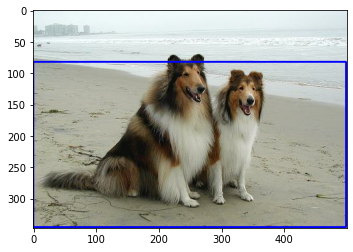

In [184]:
rect = get_bbox(grad_cam_image)

image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## IoU 구하기

1. 정답 바운딩 박스 (ground truth)와 예측값 바운딩 박스 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만든다.

In [164]:
def get_iou(gt_bbox, pred_bbox):
    y_min = max(gt_bbox[0], pred_bbox[0])
    x_min= max(gt_bbox[1], pred_bbox[1])
    y_max = min(gt_bbox[2], pred_bbox[2])
    x_max = min(gt_bbox[3], pred_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    boxBArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

2. CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 본다.

In [170]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  
        rect[:,0].min()/float(image.shape[1]), 
        rect[:,1].max()/float(image.shape[0]), 
        rect[:,0].max()/float(image.shape[1]) 
    ]
    return bbox

CAM의 IoU 

In [173]:
rect = get_bbox(cam_image)
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.35141132309225515

Grad-CAM의 IoU

In [185]:
rect_grad = get_bbox(grad_cam_image)
pred_bbox_grad = rect_to_minmax(rect_grad, item['image'])
get_iou(pred_bbox_grad, item['objects']['bbox'][0])

0.47989324836422226